# Foreign Exchange Forecasting using LSTMs

In [6]:
import pandas as pd
import numpy as np

from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

In [7]:
# Google Spreadsheet ID
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = ['USD/IDR', 'EUR/IDR', 'JPY/IDR']

# USD-IDR

## Data Overview
From Google Finance

In [8]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME[0]}'
df = pd.read_csv(url)

# Drop unused columns
df = df.drop('Unnamed: 2', axis=1)

# Convert Date columns to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1977 non-null   datetime64[ns]
 1   Close   1977 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.0 KB


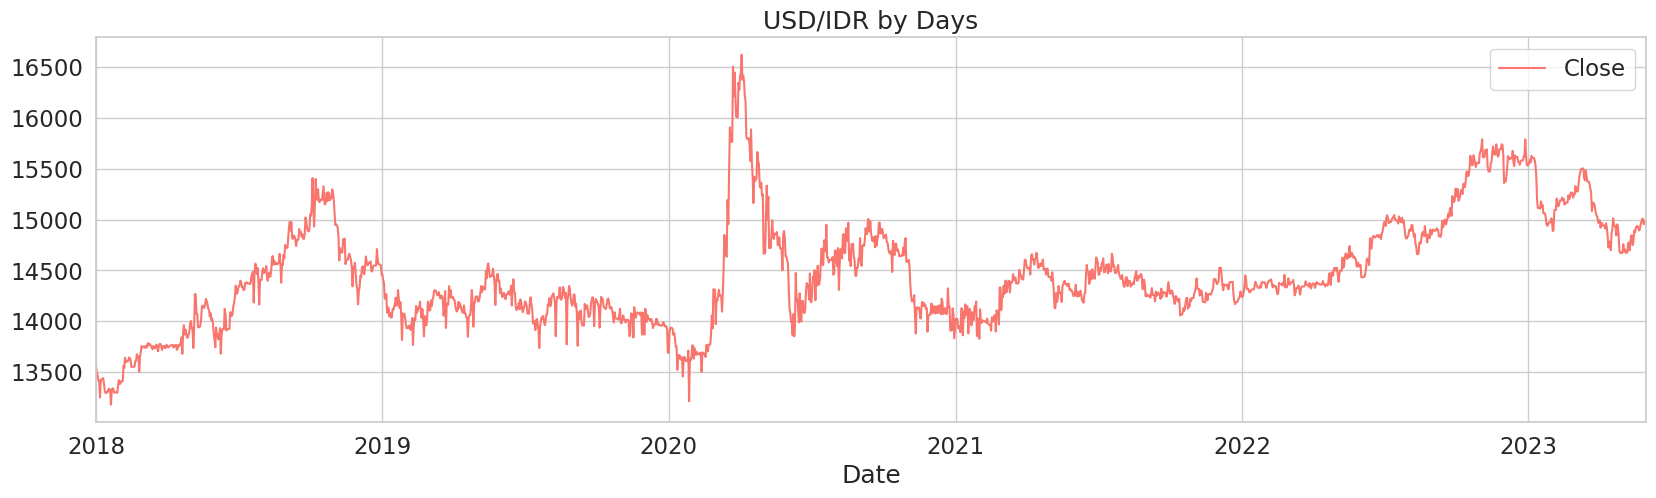

In [9]:
dfplot = df.copy()
dfplot = dfplot.groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
dfplot = dfplot.set_index('Date')

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = dfplot.plot(style='', figsize=(20,5), color=color_pal[0], title='USD/IDR by Days')

## Data preprocessing

In [10]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1977, 1)

## Making sequences

In [11]:
SEQ_LEN = 6
SPLIT = 0.90

def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = SPLIT)

## Building LSTM model

In [12]:
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(units=1))

2023-06-17 09:41:31.488363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-17 09:41:31.647203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-17 09:41:31.647474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-17 09:41:31.650180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-17 09:41:31.650351: I tensorflow/compile

## Training

In [13]:
BATCH_SIZE = 32

model.compile(
    loss='mean_squared_error',
    metrics=['mae'],
    optimizer='adam',
)
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    validation_split=0.1)

Epoch 1/50


2023-06-17 09:41:37.437164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-17 09:41:37.438801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-17 09:41:37.439829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

49/50 [============================>.] - ETA: 0s - loss: 0.0194 - mae: 0.0951

2023-06-17 09:41:44.940123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-17 09:41:44.941334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-17 09:41:44.942622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

50/50 [==============================] - 8s 24ms/step - loss: 0.0191 - mae: 0.0940 - val_loss: 0.0080 - val_mae: 0.0812
Epoch 2/50
50/50 [==============================] - 1s 10ms/step - loss: 0.0019 - mae: 0.0299 - val_loss: 7.7635e-04 - val_mae: 0.0229
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0016 - mae: 0.0269 - val_loss: 5.6378e-04 - val_mae: 0.0190
Epoch 4/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0016 - mae: 0.0278 - val_loss: 5.7293e-04 - val_mae: 0.0189
Epoch 5/50
50/50 [==============================] - 1s 12ms/step - loss: 0.0015 - mae: 0.0270 - val_loss: 5.6199e-04 - val_mae: 0.0188
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0015 - mae: 0.0266 - val_loss: 7.2963e-04 - val_mae: 0.0219
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.0015 - mae: 0.0267 - val_loss: 0.0010 - val_mae: 0.0265
Epoch 8/50
50/50 [==============================] - 0s 9ms/step - loss: 0.

In [14]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 5ms/step - loss: 4.8969e-04 - mae: 0.0170


[0.0004896941245533526, 0.017008807510137558]

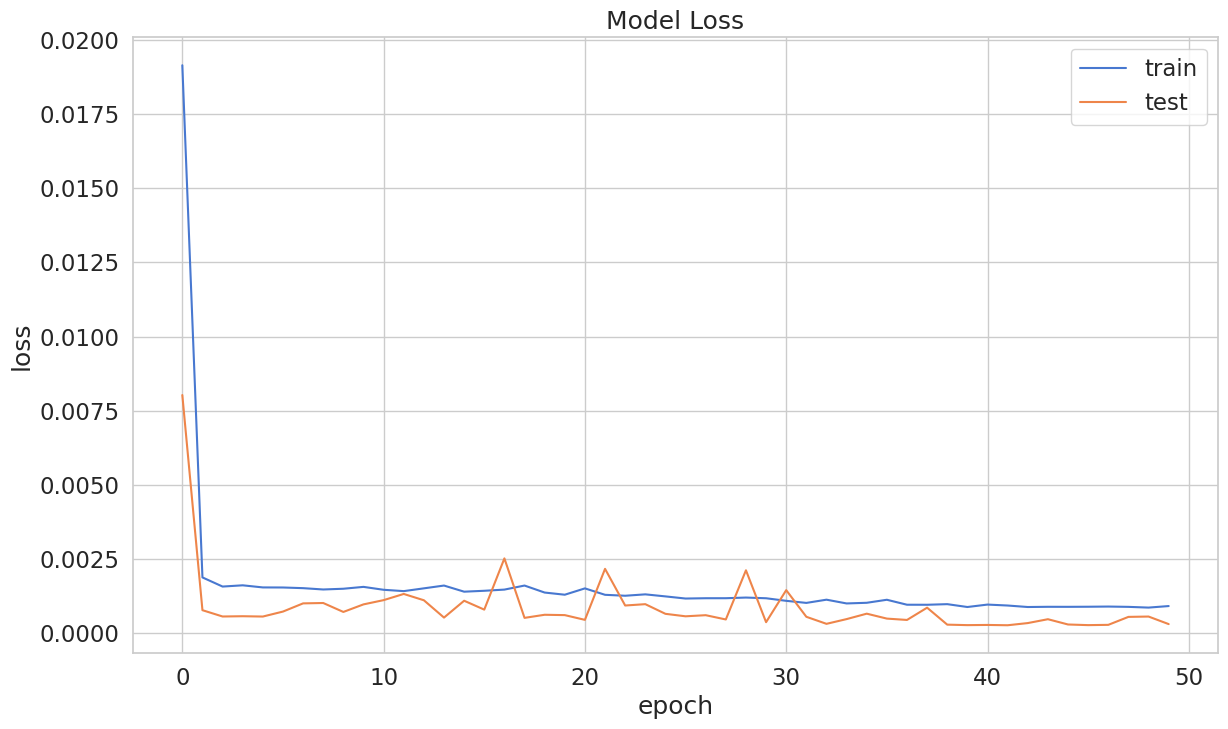

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Prediction

In [16]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

2023-06-17 09:42:11.080508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-17 09:42:11.082926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-17 09:42:11.084112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 5ms/step


2023-06-17 09:42:11.300745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-17 09:42:11.301838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-17 09:42:11.303006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

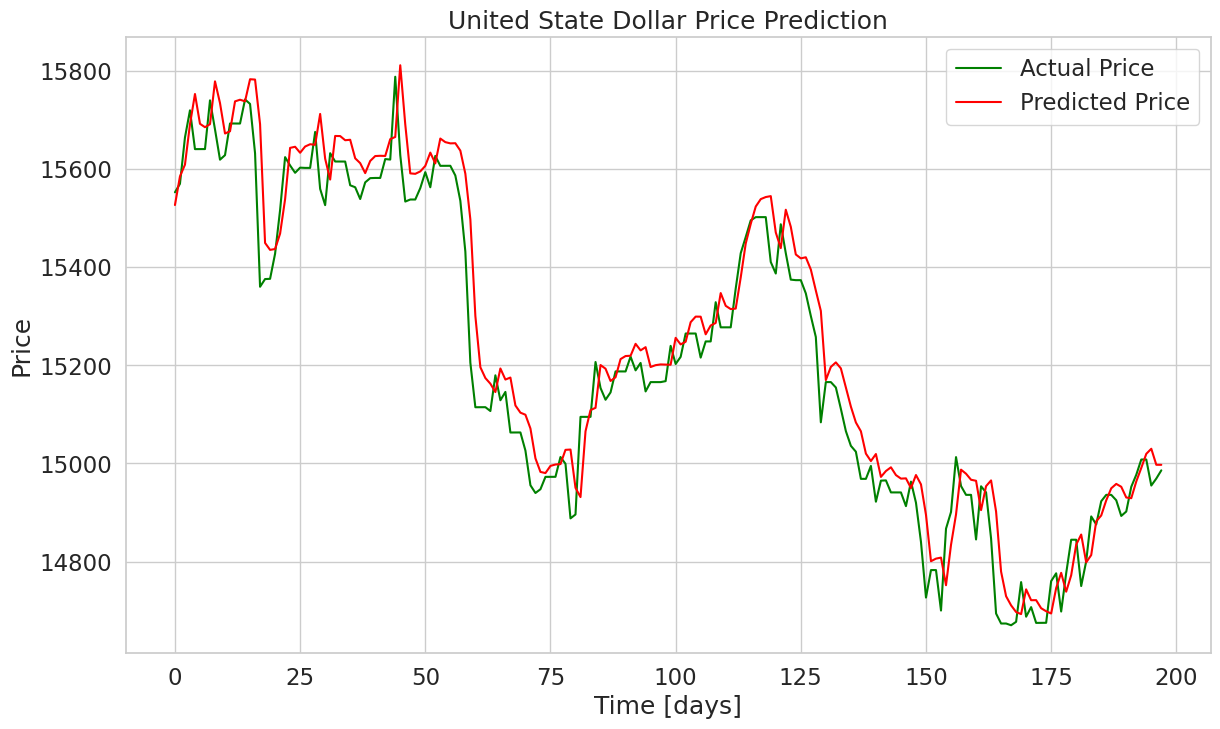

In [17]:
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('United State Dollar Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [18]:
def matrices(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print("Mean Squared Error for prediction :", mse)
    print("Mean Absolute Error for prediction :", mae)
    print("Root Mean Squared Error for prediction :", rmse)

matrices(y_test_inverse, y_hat_inverse)

Mean Squared Error for prediction : 5805.633961914723
Mean Absolute Error for prediction : 58.56472044665404
Root Mean Squared Error for prediction : 76.19471085262234
